### Sensors

In [1]:
import os.path as op
import numpy as np
import pandas as pd
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from mne.beamformer import make_lcmv, apply_lcmv_epochs
from base import ensure_dir
from config import *
import gc
import os
import sys
import os
import matplotlib.pyplot as plt

times = np.linspace(-0.2, 0.6, 82)

# params
subjects = SUBJS
subject = subjects[0]
lock = "stim"
trial_type = 'pattern'

data_path = DATA_DIR
subjects_dir = FREESURFER_DIR
folds = 10
solver = 'lbfgs'
scoring = "accuracy"

is_cluster = os.getenv("SLURM_ARRAY_TASK_ID") is not None
overwrite = False
verbose = True
jobs = -1

epoch_num = 1

In [2]:
figures_dir = FIGURES_DIR / 'sensors_vs_source'
ensure_dir(figures_dir)

In [3]:
# set-up the classifier and cv structure
clf = make_pipeline(StandardScaler(), LogisticRegression(C=1.0, max_iter=100000, solver=solver, class_weight="balanced", random_state=42, n_jobs=jobs))
# clf = make_pipeline(StandardScaler(), LogisticRegressionCV(max_iter=100000, solver=solver, class_weight="balanced", random_state=42, n_jobs=-1))
clf = SlidingEstimator(clf, scoring=scoring, n_jobs=jobs, verbose=verbose)
cv = StratifiedKFold(folds, shuffle=True, random_state=42)

In [4]:
epo_dir = DATA_DIR / lock
epo_fnames = [epo_dir / f'{f}' for f in sorted(os.listdir(epo_dir)) if '.fif' in f and subject in f]
all_epo = [mne.read_epochs(fname, preload=True, verbose="error") for fname in epo_fnames]
for epoch in all_epo: # see mne.preprocessing.maxwell_filter to realign the runs to a common head position. On raw data.
    epoch.info['dev_head_t'] = all_epo[0].info['dev_head_t']
epoch = mne.concatenate_epochs(all_epo, on_mismatch='raise')

beh_dir = data_path / 'behav'
beh_fnames = [beh_dir / f'{f}' for f in sorted(os.listdir(beh_dir)) if '.pkl' in f and subject in f]
all_beh = [pd.read_pickle(fname) for fname in beh_fnames]
behav = pd.concat(all_beh)

network = NETWORKS[0]
label_path = RESULTS_DIR / 'networks_200_7' / subject
vis_lh, vis_rh = mne.read_label(label_path / f'{network}-lh.label'), mne.read_label(label_path / f'{network}-rh.label')

network = NETWORKS[1]
label_path = RESULTS_DIR / 'networks_200_7' / subject
mot_lh, mot_rh = mne.read_label(label_path / f'{network}-lh.label'), mne.read_label(label_path / f'{network}-rh.label')

network = NETWORKS[4]
label_path = RESULTS_DIR / 'networks_200_7' / subject
limb_lh, limb_rh = mne.read_label(label_path / f'{network}-lh.label'), mne.read_label(label_path / f'{network}-rh.label')


Not setting metadata
1383 matching events found
Applying baseline correction (mode: mean)


In [5]:
pattern = behav.trialtypes == 1
X = epoch.get_data()[pattern][:500]
y = behav.positions[pattern][:500]
sensor_scores = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

/var/folders/0x/4l778zdn0l524g42s5_nc48h0000gn/T/ipykernel_1747/2308183527.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epoch.get_data()[pattern][:500]
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.6s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.4s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.6s finished


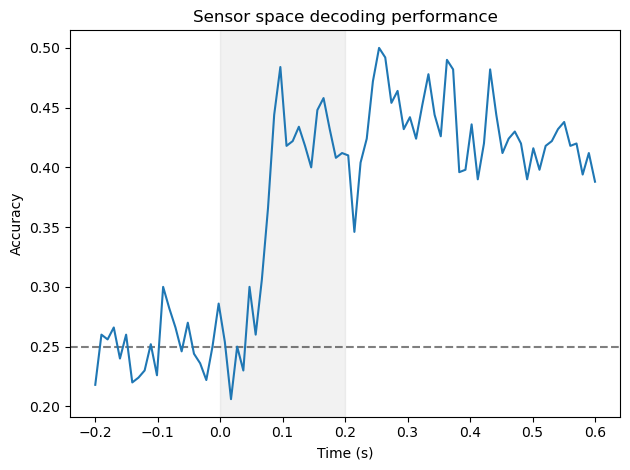

In [6]:
fig, ax = plt.subplots(1, 1)
ax.axvspan(0, 0.2, alpha=0.1, color='grey')
ax.axhline(0.25, alpha=0.5, color='k', linestyle='--')
ax.plot(times, sensor_scores.mean(0))
ax.set_title('Sensor space decoding performance')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Accuracy')
fig.tight_layout()
fig.savefig(figures_dir / 'sensor_decoding.pdf', transparent=True)

In [7]:
from sklearn.decomposition import PCA
from mne.decoding import UnsupervisedSpatialFilter
pca = UnsupervisedSpatialFilter(PCA(1000), average=False)
data_cov = mne.compute_covariance(epoch, tmin=0, tmax=.6, method="empirical", rank="info", verbose=verbose)
noise_cov = mne.compute_covariance(epoch, tmin=-.2, tmax=0, method="empirical", rank="info", verbose=verbose)
# conpute rank
rank = mne.compute_rank(data_cov, info=epoch.info, rank=None, tol_kind='relative', verbose=verbose)
# read forward solution
fwd_fname = RESULTS_DIR / "fwd" / lock / f"{subject}-all-fwd.fif"
fwd = mne.read_forward_solution(fwd_fname, verbose=verbose)
# compute source estimates
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori=None, weight_norm="unit-noise-gain",
                    rank=rank, reduce_rank=True, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
none_data = np.array([np.real(stc.data) for stc in stcs])
none_data = pca.fit_transform(none_data)
# Visual
none_vis = np.array([np.real(stc.in_label(vis_lh + vis_rh).data) for stc in stcs])
# Motor
none_mot = np.array([np.real(stc.in_label(mot_lh + mot_rh).data) for stc in stcs])
# Limbic
none_limb = np.array([np.real(stc.in_label(limb_lh + limb_rh).data) for stc in stcs])

Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 85746
[done]
Reducing data rank from 246 -> 246
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 29043
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.7e-13 (2.2e-16 eps * 246 dim * 3.1  max singular value)
    Estimated rank (mag): 246
    MAG: rank 246 computed from 246 data channels with 0 projectors
Reading forward solution from /Users/coum/Desktop/asrt/results/fwd/stim/sub01-all-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 246 channels, free orientations)
    Source spac

In [8]:
pattern = behav.trialtypes == 1
# Visual
X = none_vis[pattern][:500]
y = behav.positions[pattern][:500]
y = y.reset_index(drop=True)            
assert X.shape[0] == y.shape[0]
none_vis_sc = cross_val_multiscore(clf, X, y, cv=cv, n_jobs=jobs, verbose=verbose)
# Motor
X = none_mot[pattern][:500]
assert X.shape[0] == y.shape[0]
none_mot_sc = cross_val_multiscore(clf, X, y, cv=cv, n_jobs=jobs, verbose=verbose)
# Limbic
X = none_limb[pattern][:500]
assert X.shape[0] == y.shape[0]
none_limb_sc = cross_val_multiscore(clf, X, y, cv=cv, n_jobs=jobs, verbose=verbose)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]



  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]




  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]





  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]






  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]







  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]








  1%|          | Fitting SlidingEstimator : 1/82 [00:13<17:52,   13.24s/it][A
  1%|          | Fitting SlidingEstimator : 1/82 [00:13<17:39,   13.09s/it]
  2%|▏         | Fitting SlidingEstimator : 2/82 [00:13<09:01,    6.77s/it]
  4%|▎   

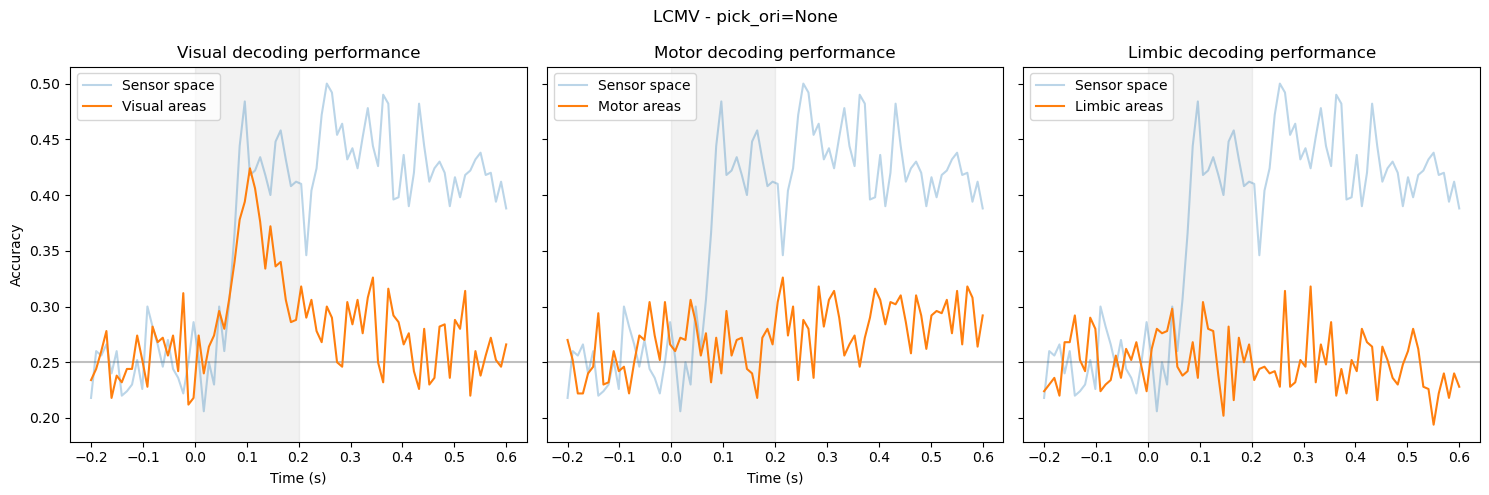

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for ax in (ax1, ax2, ax3):
    ax.axvspan(0, 0.2, color='grey', alpha=0.1)
    ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
    ax.plot(times, sensor_scores.mean(0), label='Sensor space', alpha=0.3)
# Visual
ax1.plot(times, none_vis_sc.mean(0), label='Visual areas')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Visual decoding performance')
# Motor
ax2.plot(times, none_mot_sc.mean(0), label='Motor areas')
ax2.set_xlabel('Time (s)')
ax2.set_title('Motor decoding performance')
# Limbic
ax3.plot(times, none_limb_sc.mean(0), label='Limbic areas')
ax3.set_title('Limbic decoding performance')
for ax in (ax1, ax2, ax3):
    ax.legend(loc='upper left')
fig.suptitle(f'LCMV - pick_ori=None')
fig.tight_layout()
# fig.savefig(figures_dir / 'lcmv_ori_none.pdf', transparent=True)

In [10]:
# compute source estimates
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori='max-power', weight_norm="unit-noise-gain",
                    rank=rank, reduce_rank=True, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
maxp_data = np.array([np.real(stc.data) for stc in stcs])
maxp_data = pca.fit_transform(maxp_data)

# Visual
maxp_vis = np.array([np.real(stc.in_label(vis_lh + vis_rh).data) for stc in stcs])
# Motor
maxp_mot = np.array([np.real(stc.in_label(mot_lh + mot_rh).data) for stc in stcs])
# Limbic
maxp_limb = np.array([np.real(stc.in_label(limb_lh + limb_rh).data) for stc in stcs])

pattern = behav.trialtypes == 1
# Visual
X = maxp_vis[pattern][:500]
y = behav.positions[pattern][:500]
y = y.reset_index(drop=True)            
assert X.shape[0] == y.shape[0]
maxp_vis_sc = cross_val_multiscore(clf, X, y, cv=cv, n_jobs=jobs, verbose=verbose)
# Motor
X = maxp_mot[pattern][:500]
assert X.shape[0] == y.shape[0]
maxp_mot_sc = cross_val_multiscore(clf, X, y, cv=cv, n_jobs=jobs, verbose=verbose)
# Limbic
X = maxp_limb[pattern][:500]
assert X.shape[0] == y.shape[0]
maxp_limb_sc = cross_val_multiscore(clf, X, y, cv=cv, n_jobs=jobs, verbose=verbose)

Computing rank from covariance with rank={'mag': 246}
Computing rank from covariance with rank={'mag': 246}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch : 14
Processing epoch : 15
Processing epoch : 16
Processing epoch : 17
Processing epoch : 18
Processing epoch : 19
Processing epoch : 20
Processi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]



  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]





  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]






  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]




  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]







  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]








  1%|          | Fitting SlidingEstimator : 1/82 [00:16<21:59,   16.29s/it][A
  1%|          | Fitting SlidingEstimator : 1/82 [00:16<22:32,   16.70s/it]

  1%|          | Fitting SlidingEstimator : 1/82 [00:18<24:37,   18.24s/it]

  2%|▏ 

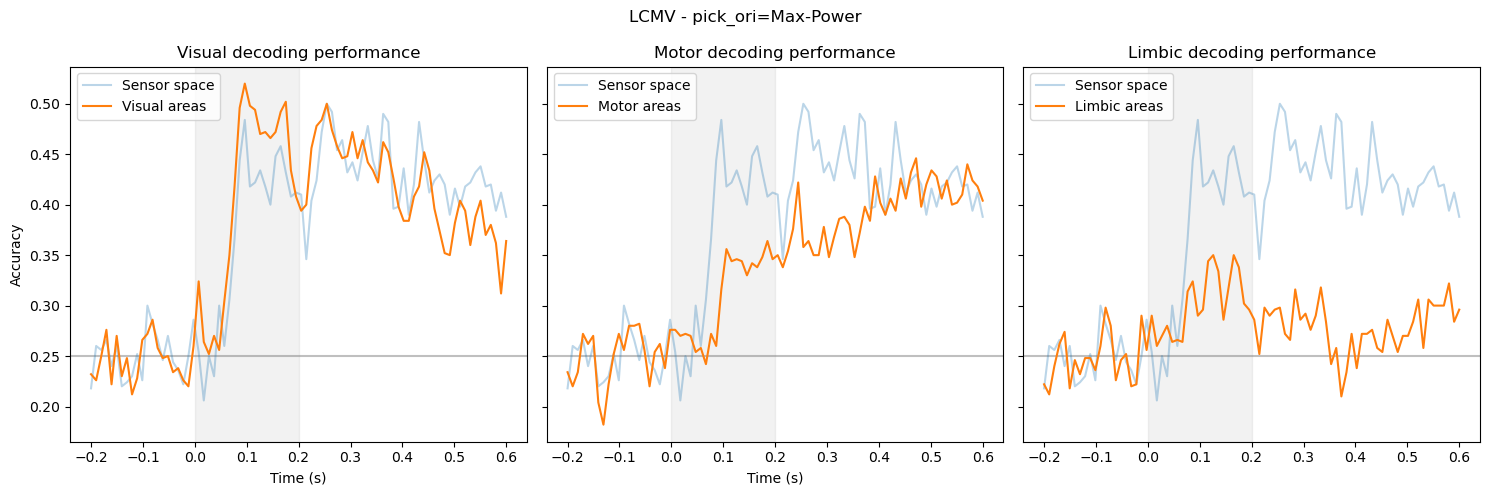

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for ax in (ax1, ax2, ax3):
    ax.axvspan(0, 0.2, color='grey', alpha=0.1)
    ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
    ax.plot(times, sensor_scores.mean(0), label='Sensor space', alpha=0.3)
# Visual
ax1.plot(times, maxp_vis_sc.mean(0), label='Visual areas')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Visual decoding performance')
# Motor
ax2.plot(times, maxp_mot_sc.mean(0), label='Motor areas')
ax2.set_xlabel('Time (s)')
ax2.set_title('Motor decoding performance')
# Limbic
ax3.plot(times, maxp_limb_sc.mean(0), label='Limbic areas')
ax3.set_title('Limbic decoding performance')
for ax in (ax1, ax2, ax3):
    ax.legend(loc='upper left')
fig.suptitle(f'LCMV - pick_ori=Max-Power')
fig.tight_layout()
# fig.savefig(figures_dir / 'lcmv_ori_maxp.pdf', transparent=True)

In [12]:
# Singular Value Decomposition
def svd(vector_data):
    # Initialize an array for storing the dominant orientation time series
    dominant_data = np.zeros((vector_data.shape[0], vector_data.shape[1], vector_data.shape[-1]))  # (294, 8196, 82)
    for trial in range(vector_data.shape[0]):  # Loop over trials
        for source in range(vector_data.shape[1]):  # Loop over sources
            u, s, vh = np.linalg.svd(vector_data[trial, source, :, :], full_matrices=False)  # SVD over orientation axis (3)
            dominant_time_series = vh[0, :] * s[0]  # First right singular vector weighted by singular value
            dominant_data[trial, source, :] = dominant_time_series  # Store in new array
    return dominant_data

In [13]:
# compute source estimates
filters = make_lcmv(epoch.info, fwd, data_cov, reg=0.05, noise_cov=noise_cov,
                    pick_ori='vector', weight_norm="unit-noise-gain",
                    rank=rank, reduce_rank=True, verbose=verbose)
stcs = apply_lcmv_epochs(epoch, filters=filters, verbose=verbose)
data = np.array([np.real(stc.in_label(vis_lh + vis_rh).data) for stc in stcs])
svd_data = svd(data)
vect_data = pca.fit_transform(svd_data)

# Visual
vect_vis = np.array([np.real(stc.in_label(vis_lh + vis_rh).data) for stc in stcs])
vect_vis = svd(vect_vis)
# Motor
vect_mot = np.array([np.real(stc.in_label(mot_lh + mot_rh).data) for stc in stcs])
vect_mot = svd(vect_mot)
# Limbic
vect_limb = np.array([np.real(stc.in_label(limb_lh + limb_rh).data) for stc in stcs])
vect_limb = svd(vect_limb)

pattern = behav.trialtypes == 1
# Visual
X = vect_vis[pattern][:500]
y = behav.positions[pattern][:500]
y = y.reset_index(drop=True)            
assert X.shape[0] == y.shape[0]
vect_vis_sc = cross_val_multiscore(clf, X, y, cv=cv, n_jobs=jobs, verbose=verbose)
# Motor
X = vect_mot[pattern][:500]
assert X.shape[0] == y.shape[0]
vect_mot_sc = cross_val_multiscore(clf, X, y, cv=cv, n_jobs=jobs, verbose=verbose)
# Limbic
X = vect_limb[pattern][:500]
assert X.shape[0] == y.shape[0]
vect_limb_sc = cross_val_multiscore(clf, X, y, cv=cv, n_jobs=jobs, verbose=verbose)

Computing rank from covariance with rank={'mag': 246}
Computing rank from covariance with rank={'mag': 246}
Making LCMV beamformer with rank {'mag': 246}
Computing inverse operator with 246 channels.
    246 out of 246 channels remain after picking
Selected 246 channels
Whitening the forward solution.
Computing rank from covariance with rank={'mag': 246}
    Setting small MAG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 8196 sources
Filter computation complete
Processing epoch : 1
Processing epoch : 2
Processing epoch : 3
Processing epoch : 4
Processing epoch : 5
Processing epoch : 6
Processing epoch : 7
Processing epoch : 8
Processing epoch : 9
Processing epoch : 10
Processing epoch : 11
Processing epoch : 12
Processing epoch : 13
Processing epoch : 14
Processing epoch : 15
Processing epoch : 16
Processing epoch : 17
Processing epoch : 18
Processing epoch : 19
Processing epoch : 20
Processi

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]
  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]



  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]




  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]





  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]






  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]







  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]








  7%|▋         | Fitting SlidingEstimator : 6/82 [00:06<01:18,    1.03s/it][A
 11%|█         | Fitting SlidingEstimator : 9/82 [00:07<00:49,    1.47it/s]

 12%|█▏        | Fitting SlidingEstimator : 10/82 [00:07<00:45,    1.60it/s][A
 15%|

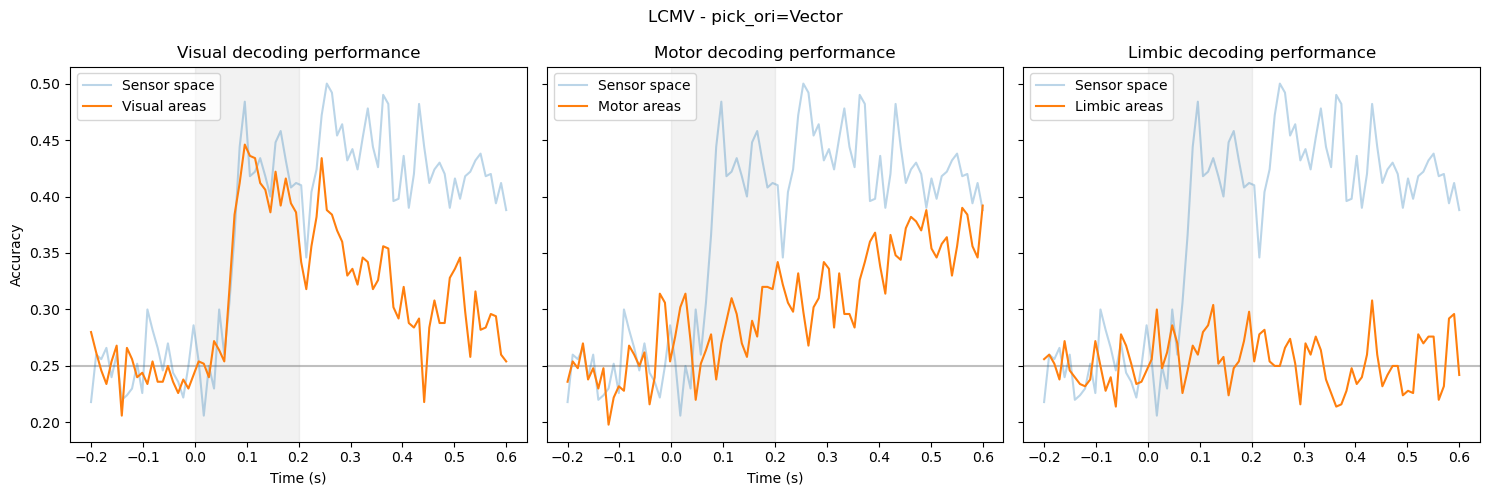

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for ax in (ax1, ax2, ax3):
    ax.axvspan(0, 0.2, color='grey', alpha=0.1)
    ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
    ax.plot(times, sensor_scores.mean(0), label='Sensor space', alpha=0.3)
# Visual
ax1.plot(times, vect_vis_sc.mean(0), label='Visual areas')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Accuracy')
ax1.set_title('Visual decoding performance')
# Motor
ax2.plot(times, vect_mot_sc.mean(0), label='Motor areas')
ax2.set_xlabel('Time (s)')
ax2.set_title('Motor decoding performance')
# Limbic
ax3.plot(times, vect_limb_sc.mean(0), label='Limbic areas')
ax3.set_title('Limbic decoding performance')
for ax in (ax1, ax2, ax3):
    ax.legend(loc='upper left')
fig.suptitle(f'LCMV - pick_ori=Vector')
fig.tight_layout()
# fig.savefig(figures_dir / 'lcmv_ori_vector.pdf', transparent=True)

In [15]:
X = none_data[pattern][:500]
none_scores = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)
X = maxp_data[pattern][:500]
maxp_scores = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)
X = vect_data[pattern][:500]
vect_scores = cross_val_multiscore(clf, X, y, cv=cv, verbose=verbose)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.4s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.3s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.4s remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/82 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.5s finished


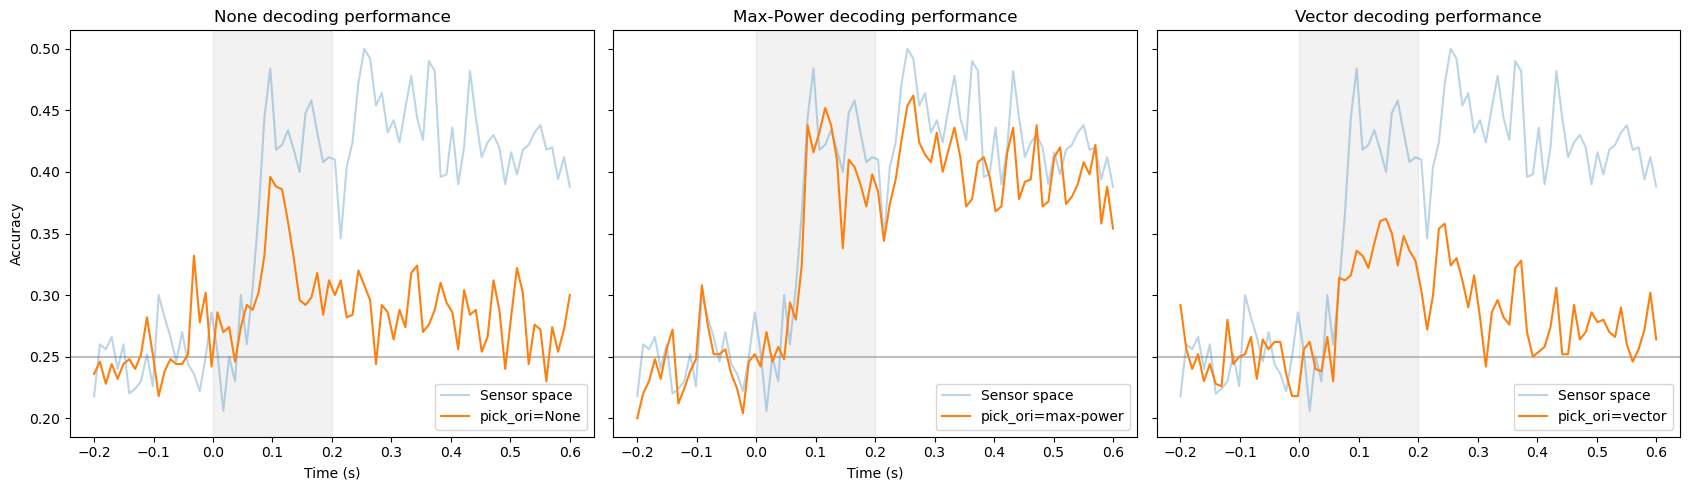

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5), sharey=True)
for ax in (ax1, ax2, ax3):
    ax.axvspan(0, 0.2, color='grey', alpha=0.1)
    ax.axhline(.25, color='grey', linestyle='-', alpha=0.5)
    ax.plot(times, sensor_scores.mean(0), label='Sensor space', alpha=0.3)
# None
ax1.plot(times, none_scores.mean(0), label='pick_ori=None')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Accuracy')
ax1.set_title('None decoding performance')
# Max-Power
ax2.plot(times, maxp_scores.mean(0), label='pick_ori=max-power')
ax2.set_xlabel('Time (s)')
ax2.set_title('Max-Power decoding performance')
# Vector
ax3.plot(times, vect_scores.mean(0), label='pick_ori=vector')
ax3.set_title('Vector decoding performance')
for ax in (ax1, ax2, ax3):
    ax.legend()
fig.tight_layout()
# fig.savefig(figures_dir / 'lcmv_ori_all.pdf', transparent=True)